# Donnée Static Grid Model

1. Accès au dataset des lignes françaises du GRT RTE en date de 2019. Données en accès : I_max saisonniers, stations, longueurs, caractéristiques
Source : https://www.services-rte.com/en/learn-more-about-our-services/static-grid-model.html
Problèmes éventuels : données lacunaire et datées (2019)

2. Dataset : [Lignes aériennes RTE – nouveau découpage (au 10 juin 2024)](https://odre.opendatasoft.com/explore/dataset/lignes-aeriennes-rte-nv/information/?disjunctive.etat&disjunctive.tension&dataChart=eyJxdWVyaWVzIjpbeyJjaGFydHMiOlt7InR5cGUiOiJjb2x1bW4iLCJmdW5jIjoiQ09VTlQiLCJ5QXhpcyI6ImxvbmdpdHVkZV9kZWJ1dF9zZWdtZW50Iiwic2NpZW50aWZpY0Rpc3BsYXkiOnRydWUsImNvbG9yIjoicmFuZ2UtQWNjZW50In1dLCJ4QXhpcyI6InRlbnNpb24iLCJtYXhwb2ludHMiOm51bGwsInNvcnQiOiIiLCJzZXJpZXNCcmVha2Rvd24iOiJldGF0Iiwic2VyaWVzQnJlYWtkb3duVGltZXNjYWxlIjoiIiwiY29uZmlnIjp7ImRhdGFzZXQiOiJsaWduZXMtYWVyaWVubmVzLXJ0ZS1udiIsIm9wdGlvbnMiOnsiZGlzanVuY3RpdmUuZXRhdCI6dHJ1ZSwiZGlzanVuY3RpdmUudGVuc2lvbiI6dHJ1ZX19fV0sInRpbWVzY2FsZSI6IiIsImRpc3BsYXlMZWdlbmQiOnRydWUsImFsaWduTW9udGgiOnRydWV9&location=13,45.56282,4.83351&basemap=jawg.light) / 

## Importations de librairie

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json 
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

from sklearn.cluster import DBSCAN
from sklearn.linear_model import LinearRegression

from utils import *

## DATA Lignes

### Ligne 2019 + caractéristiques : THT

#### Ouvrir le dataset

In [109]:
path = '/Users/matthiasmolenat/repos/congestion/data/RT_ligne_2019.csv'
df_ligne_RT_2019 = pd.read_csv(path,delimiter=';', decimal=',',index_col=False)
df_ligne_RT_2019.drop('Unnamed: 14', axis = 1, inplace=True)
df_ligne_RT_2019.head()

,ref,Circuit name,sub_1_short,sub_2_short,Voltage level (kV),I_max_Summer,I_max_Interseason_1,I_max_Interseason_2,I_max_Winter,Resistance R (Ω),Reactance X (Ω),Capacity (nF),Half-Susceptance Hd/2 (μS),Length (m)
0,AIRVAL61BONN6,LIT 225kV N0 1 AIRVAULT-BONNEAU,AIRVA,BONN6,225,932.0,932.0,1145.0,1145.0,3.064,20.350,762.736,119.810,52792
1,AIRVAL61JUMEA,LIT 225kV N0 1 AIRVAULT-JUMEAUX (LES),AIRVA,JUMEA,225,1249.0,1337.0,1337.0,1434.0,0.330,2.212,50.501,7.933,5507
2,ALBERL61CHAV6,LIT 225kV N0 1 ALBERTVILLE-CHAVANOD,ALBER,CHAV6,225,617.0,685.0,685.0,742.0,4.460,17.210,17.210,60.000,42135
3,ALBERL61CONTA,LIT 225kV N0 1 ALBERTVILLE-CONTAMINE,ALBER,CONTA,225,565.0,673.0,673.0,765.0,2.352,10.043,225.097,35.358,24925
4,ALBERL61LONG6,LIT 225kV N0 1 ALBERTVILLE-LONGEFAN,ALBER,LONG6,225,565.0,673.0,673.0,765.0,4.486,17.749,391.180,61.446,43669


In [110]:
print(f'Shapde : {df_ligne_RT_2019.shape}')
print(f'Column names : {df_ligne_RT_2019.columns}')

Shapde : (921, 14)
Column names : Index(['ref', 'Circuit name', 'sub_1_short', 'sub_2_short',
       'Voltage level (kV)', 'I_max_Summer', 'I_max_Interseason_1',
       'I_max_Interseason_2', 'I_max_Winter', 'Resistance R (Ω)',
       'Reactance X (Ω)', 'Capacity (nF)', 'Half-Susceptance Hd/2 (μS)',
       'Length (m)'],
      dtype='object')


#### Remplacer les nan values dans les lignes s'il existe un doublon fourni en information.

In [111]:
# Group by the columns `sub_1_short`, `sub_2_short`, and `Voltage level (kV)`
group_cols = ['sub_1_short', 'sub_2_short', 'Voltage level (kV)']
df_filled = (
    df_ligne_RT_2019.groupby(group_cols)
    .apply(lambda group: group.ffill().bfill() , include_groups=False)
)
# Remove the multi-index introduced by `groupby().apply()`
df_ligne_RT_2019 = df_filled.reset_index(drop=False)

#### Drop les lignes de taille nulle

In [112]:
df_ligne_RT_2019 =  df_ligne_RT_2019[df_ligne_RT_2019['Length (m)'] > 0]
print(f'Number of Nan values : {df_ligne_RT_2019.isna().sum().sum()}')

Number of Nan values : 32


#### Drop les nans restants

In [113]:
df_ligne_RT_2019.dropna(inplace=True)

#### Visualisation : Lignes associées à un poste

In [114]:
df_poste_spe = get_row_with_str(df_ligne_RT_2019, 'MONTEUX')
df_poste_spe.head(20)

,sub_1_short,sub_2_short,Voltage level (kV),level_3,ref,Circuit name,I_max_Summer,I_max_Interseason_1,I_max_Interseason_2,I_max_Winter,Resistance R (Ω),Reactance X (Ω),Capacity (nF),Half-Susceptance Hd/2 (μS),Length (m)
92,B.MON,CHAFF,400,804,B.MONL72CHAFF,LIT 400kV N0 2 BEAUMONT-MONTEUX - CHAFFARD (LE),3465.0,3544.0,3544.0,3575.0,2.261,22.922,903.910,141.986,75994
93,B.MON,COULA,400,805,B.MONL72COULA,LIT 400kV N0 2 BEAUMONT-MONTEUX - COULANGE,3465.0,3544.0,3544.0,3575.0,1.715,19.416,710.500,111.605,61247
94,B.MON,GAMPA,225,480,B.MONL62GAMPA,LIT 225kV N0 2 BEAUMONT-MONTEUX-GAMPALOUP,880.0,992.0,992.0,1086.0,2.170,14.700,331.537,52.000,36312
95,B.MON,VALE8,225,58,B.MONL61VALE8,LIT 225kV N0 1 BEAUMONT-MONTEUX-VALENCE,695.0,782.0,782.0,855.0,1.170,5.760,80.242,23.000,14022


#### Ajout de colonnes types

In [115]:
df_ligne_RT_2019['P_max_summer (MW)']=df_ligne_RT_2019['Voltage level (kV)']*df_ligne_RT_2019['I_max_Summer']/1000
df_ligne_RT_2019['R/length'] = df_ligne_RT_2019['Resistance R (Ω)'] / df_ligne_RT_2019['Length (m)'] 

#### Récupération de donnée types :

On cherche à obtenir des grandeurs type de caractéristiques physiques pour compléter des données lacunaires. 

Hypothèse : Pour un type de ligne donné (voltage level), les grandeurs :
- $\frac{resistance}{longueur}$,
- $\frac{reactance}{longueur}$,

se conserve. 

Une étude supplémentaire doit être mené pour la valeur de $I_{max}$

##### Résistances & réactances

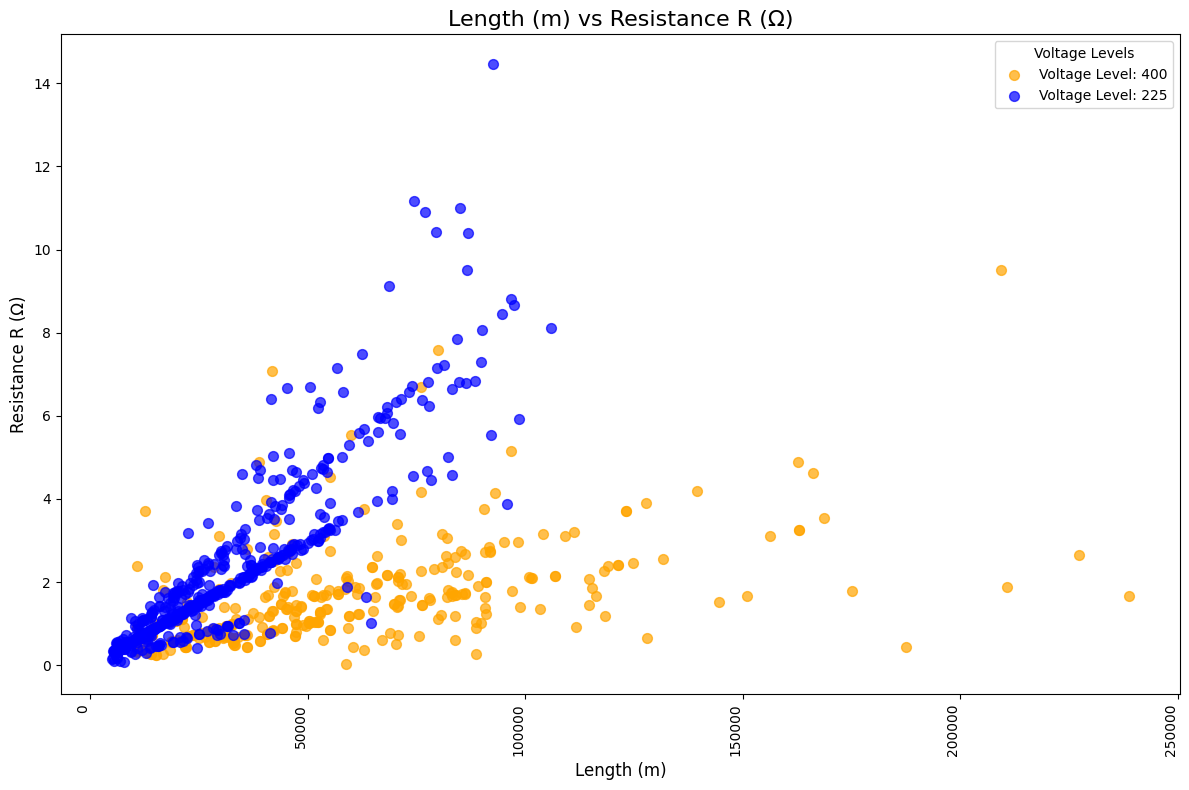

In [116]:
# Define colors for the two voltage levels
colors = {'225': 'blue', '400': 'orange'} 
X_name = 'Length (m)'
Y_name = 'Resistance R (Ω)'
scatter_plot(df_ligne_RT_2019, colors, X_name, Y_name)

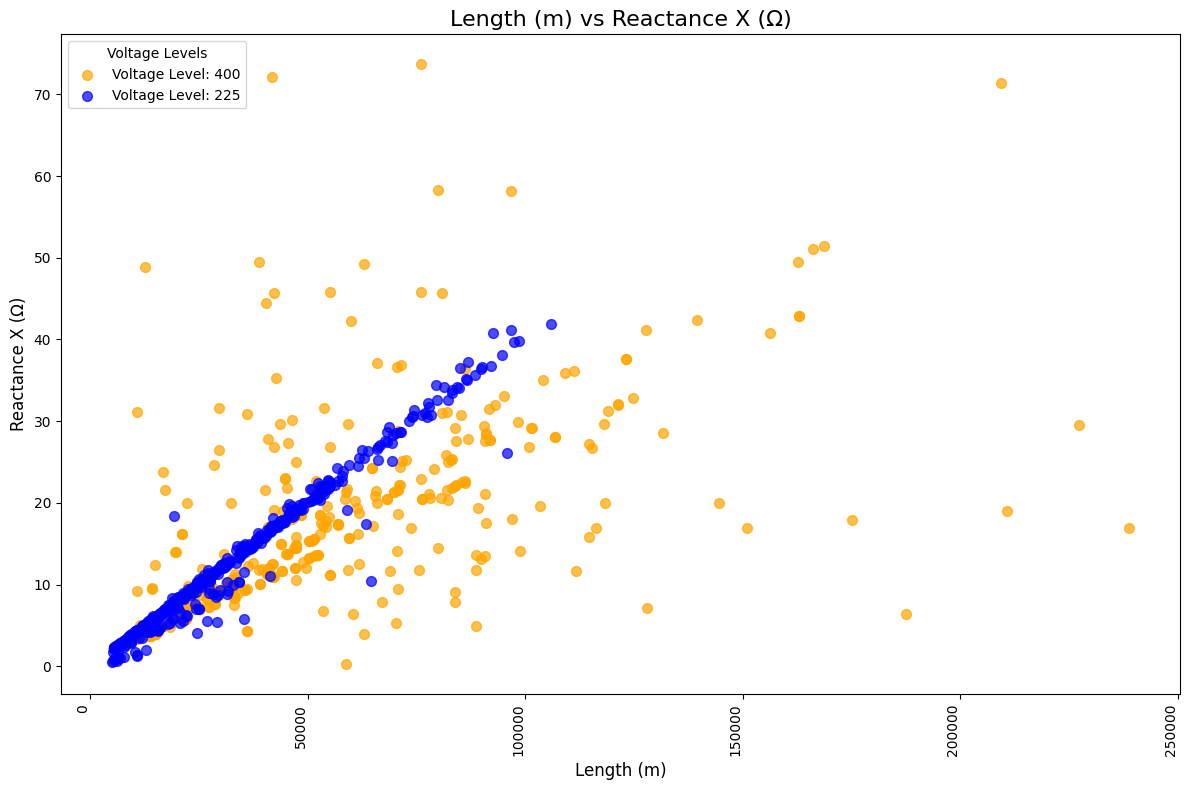

In [117]:
# Define colors for the two voltage levels
colors = {'225': 'blue', '400': 'orange'} 
X_name = 'Length (m)'
Y_name = 'Reactance X (Ω)'
scatter_plot(df_ligne_RT_2019, colors, X_name, Y_name)

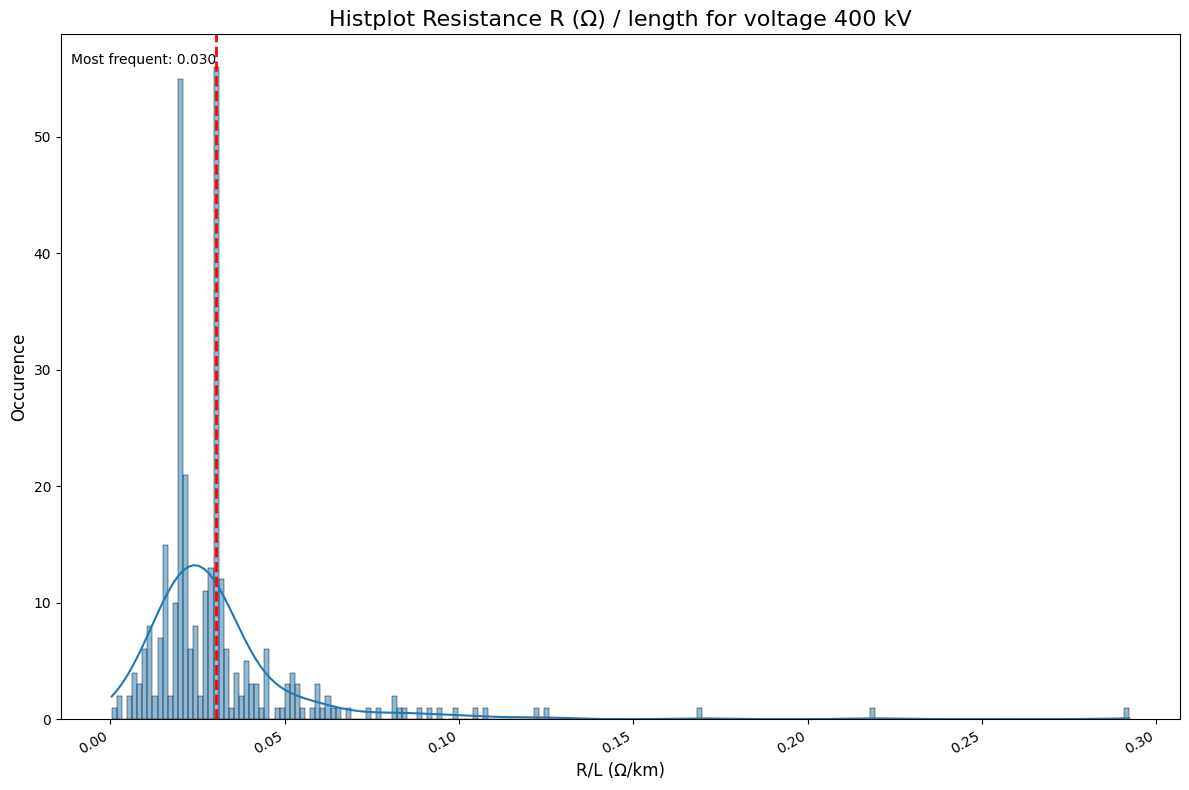

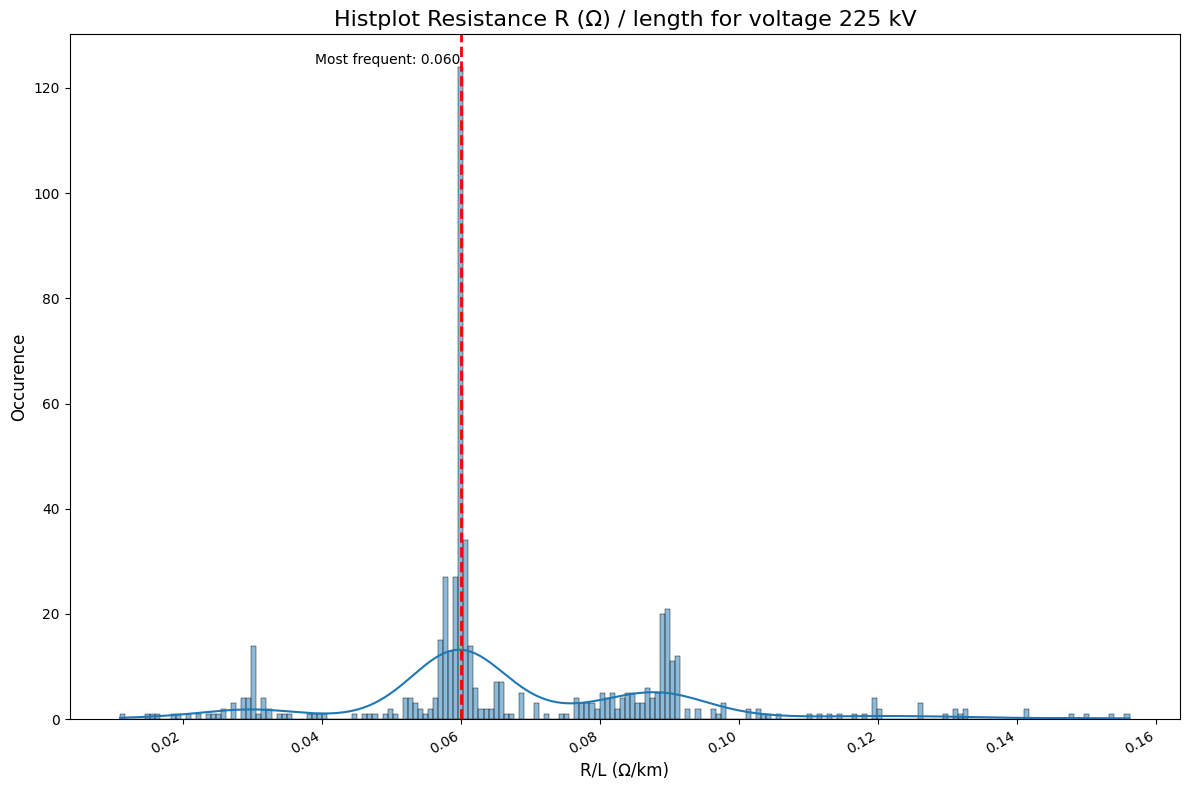

In [118]:
list_col =  ['Resistance R (Ω)', 'R/L (Ω/km)' ]
hist_plot_1(df_ligne_RT_2019, list_col)

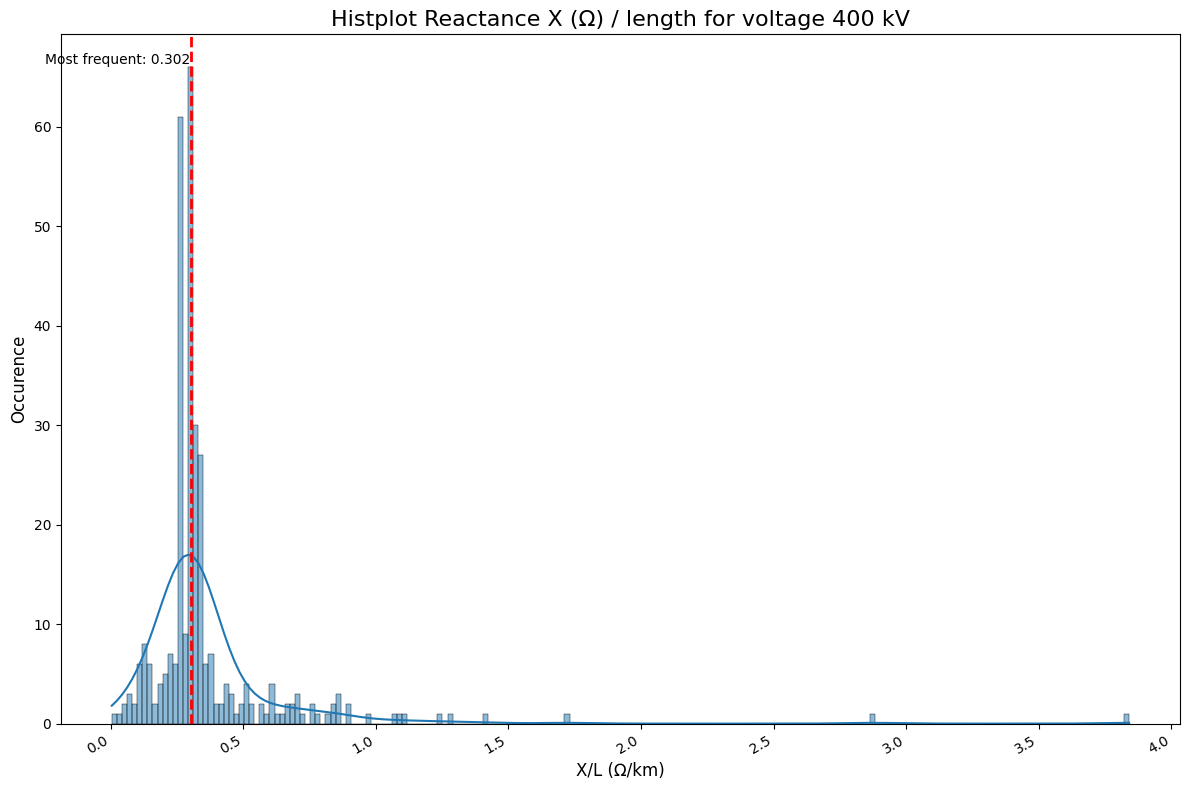

In [ ]:
list_col =  ['Reactance X (Ω)', 'X/L (Ω/km)' ]
hist_plot_1(df_ligne_RT_2019, list_col)

##### Courant max :

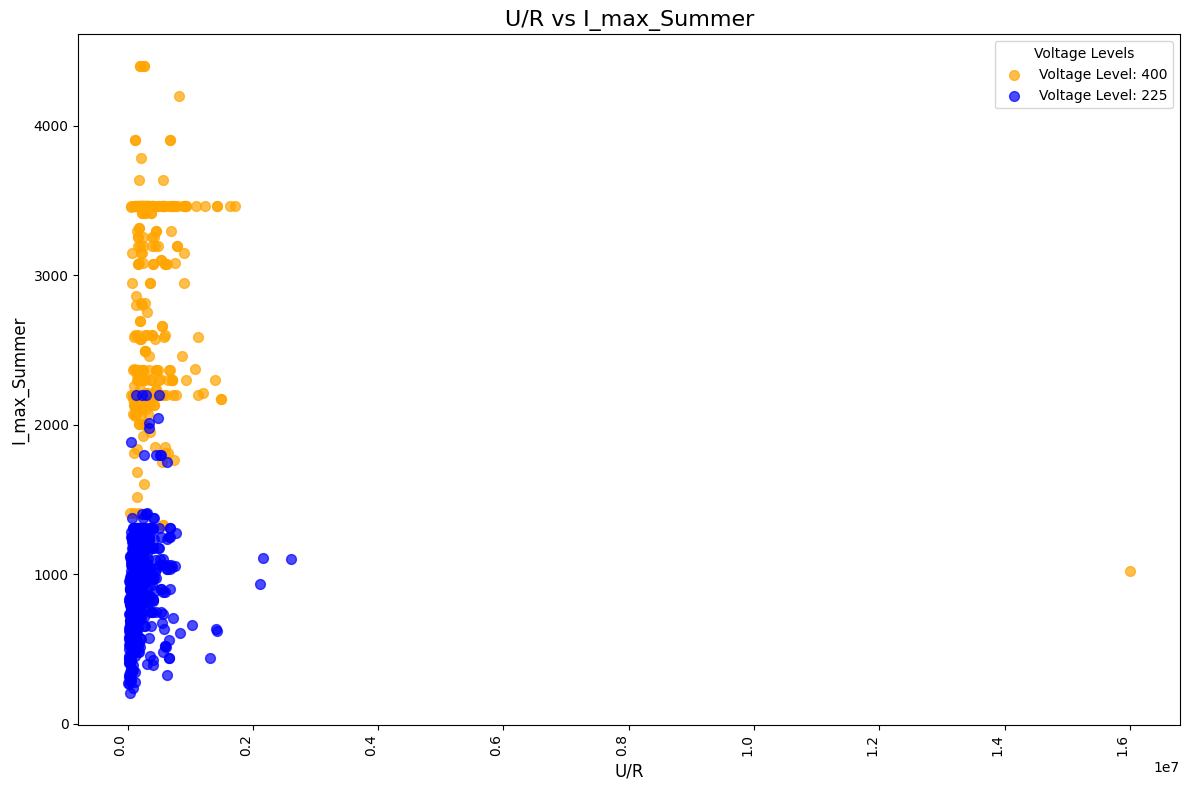

In [ ]:
df_ligne_RT_2019['U/R'] = df_ligne_RT_2019['Voltage level (kV)']*1000/df_ligne_RT_2019['Resistance R (Ω)']

# Define colors for the two voltage levels
colors = {'225': 'blue', '400': 'orange'} 
X_name = 'U/R'
Y_name = 'I_max_Summer'
scatter_plot(df_ligne_RT_2019, colors, X_name, Y_name)

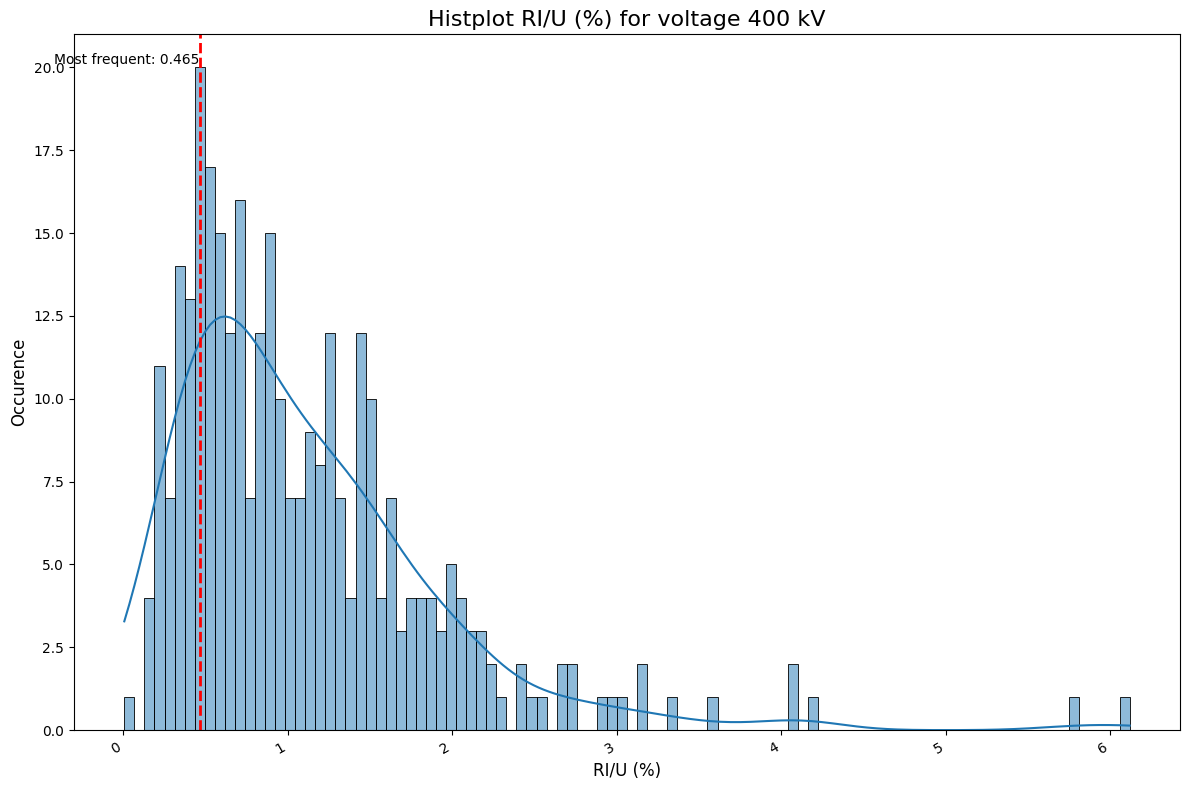

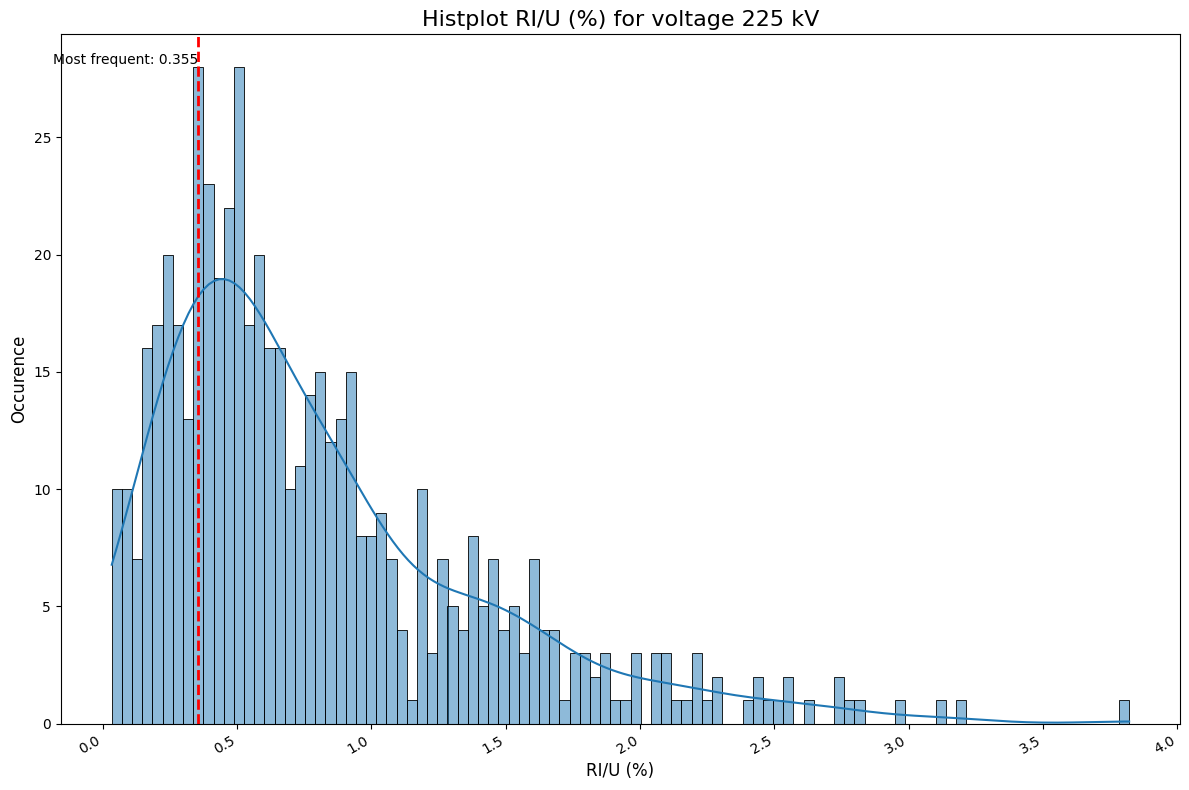

In [ ]:
Y_name = 'RI/U (%)' # Pertes / Puissance transitée
df_ligne_RT_2019['RI/U (%)'] = df_ligne_RT_2019['Resistance R (Ω)']*df_ligne_RT_2019['I_max_Summer']/df_ligne_RT_2019['Voltage level (kV)']/10
hist_plot_2(df_ligne_RT_2019, Y_name)

##### Résultats :

En tant que premières bonnes approximations, on prends :

In [ ]:
R_per_km_225 = 0.06 # Ohm / km
X_per_km_225 = 0.402 # Ohm / km

R_per_km_400 = 0.02 # Ohm / km
X_per_km_400 = 0.302 # Ohm / km

pertes_225 = 0.355 # %
pertes_400 = 0.465 # %


##### Commentaires : 

1. Pour la modélisation des lignes, on observe dans certains cas deux types distincts et de poids équivalent. Plusieurs choix possibles : moyenne, définitions de deux modèles, etc.
2. On retrouve les chiffres R/L et X/L avancés dans https://www.techno-science.net/definition/6745.html
3. intensité max : on suppose un ratio de perte autorisé max sur la ligne. $ratio = \frac{Pertes = RI^2}{Transmis = UI}$. A Approfondir? 

### Lignes 2024 

In [ ]:
path_ligne_aer = '/Users/matthiasmolenat/repos/congestion/data/lignes-aeriennes-rte-nv.csv'
df_ligne_RT_2023 = pd.read_csv(path_ligne_aer,delimiter=';')


In [ ]:
df_ligne_RT_2023.groupby('TENSION').count()

,Type ouvrage,Code ligne 1,Nom ligne 1,Propriétaire ligne 1,Etat,Source donnée,Geo Shape,Nombre circuit,Code ligne 2,Nom ligne 2,...,Code ligne 3,Nom ligne 3,Propriétaire ligne 3,Code ligne 4,Nom ligne 4,Propriétaire ligne 4,Code ligne 5,Nom ligne 5,Proprietaire ligne 5,geo_point_2d
TENSION,,,,,,,,,,,,,,,,,,,,,
150kV,68,68,68,68,68,68,68,68,6,6,...,0,0,0,0,0,0,0,0,0,68
225kV,2973,2973,2972,2972,2973,2973,2973,2973,697,697,...,17,17,17,7,7,7,1,1,1,2973
400kV,1075,1075,1073,1075,1075,1075,1075,1075,247,247,...,3,3,3,2,2,2,0,0,0,1075
45kV,99,99,99,99,99,99,99,99,13,13,...,0,0,0,0,0,0,0,0,0,99
63kV,6083,6083,6077,6083,6083,6083,6083,6083,1138,1135,...,1,1,1,0,0,0,0,0,0,6083
90kV,2646,2646,2646,2646,2646,2646,2646,2646,534,534,...,1,1,1,0,0,0,0,0,0,2646
<45kV,7,7,7,7,7,7,7,7,0,0,...,0,0,0,0,0,0,0,0,0,7
HORS TENSION,259,259,256,259,259,259,259,259,18,18,...,0,0,0,0,0,0,0,0,0,259


In [ ]:
df_ligne_RT_2023.shape

(13210, 22)

#### Calcul de la longueur des lignes

In [ ]:
lat1 = 47.561517712313425
lon1 = 5.318180972294344
lat2 = 47.55513288642406
lon2 = 5.019721383613193

print(length_from_coordinate([52.2296756, 52.406374],[ 21.0122287, 16.9251681])) # doit rendre 279 352

279352.90160430095


In [ ]:
geo_shape_index = df_ligne_RT_2023.columns.to_list().index("Geo Shape")

for index, row in df_ligne_RT_2023.iterrows():
    geo_data = json.loads(row['Geo Shape'])
    longitudes, latitudes = zip(*geo_data["coordinates"])
    df_ligne_RT_2023.at[index, "Length (m)"] = length_from_coordinate(longitudes, latitudes )
    
df_ligne_RT_2023.head()

,Type ouvrage,Code ligne 1,Nom ligne 1,Propriétaire ligne 1,Etat,TENSION,Source donnée,Geo Shape,Nombre circuit,Code ligne 2,...,Nom ligne 3,Propriétaire ligne 3,Code ligne 4,Nom ligne 4,Propriétaire ligne 4,Code ligne 5,Nom ligne 5,Proprietaire ligne 5,geo_point_2d,Length (m)
0,AERIEN,ROLAML61ZRIGO,LIAISON 225kV N0 1 PUSY - RIGOTTE (LA) - ROLAM...,MAINTENU PAR ET PROPRIETE RTE,EN EXPLOITATION,225kV,RTE,"{""coordinates"": [[5.7085749089, 47.7587819641]...",1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"47.82855513836, 5.491070148827368",50886.286325
1,AERIEN,CEBAZL31RIOM,LIAISON 63kV N0 1 CEBAZAT-RIOM,MAINTENU PAR ET PROPRIETE RTE,EN EXPLOITATION,63kV,RTE,"{""coordinates"": [[3.1228486356, 45.8837232437]...",1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"45.883755153600006, 3.12276277745",20.269845
2,AERIEN,CROIXL62P.ME5,LIAISON 225kV N0 2 CROIX (LA) - PETIT-MENIN,MAINTENU PAR ET PROPRIETE RTE,EN EXPLOITATION,225kV,RTE,"{""coordinates"": [[3.1302285506, 50.7103537288]...",1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"50.71040177335, 3.1305627690499995",74.681846
3,AERIEN,COULAL71TAVEL,LIAISON 400kV N0 1 COULANGE - TAVEL,MAINTENU PAR ET PROPRIETE RTE,EN EXPLOITATION,400kV,RTE,"{""coordinates"": [[4.7217727214, 44.6325603872]...",1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"44.632447227149996, 4.72240015955",141.019831
4,AERIEN,ARGE8L41GACE,LIAISON 90kV N0 1 ARGENTAN-GACE,MAINTENU PAR ET PROPRIETE RTE,EN EXPLOITATION,90kV,RTE,"{""coordinates"": [[-0.0089275157, 48.7425637902...",2,ARGE8L41VASTO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"48.77603848796921, 0.01729029857262007",10502.710816


#### Ligne avec nom de poste

In [ ]:
df_poste_spe = get_row_with_str(df_ligne_RT_2023, 'B.MONL72CHAFF')
df_poste_spe.head(20)

,Type ouvrage,Code ligne 1,Nom ligne 1,Propriétaire ligne 1,Etat,TENSION,Source donnée,Geo Shape,Nombre circuit,Code ligne 2,...,Nom ligne 3,Propriétaire ligne 3,Code ligne 4,Nom ligne 4,Propriétaire ligne 4,Code ligne 5,Nom ligne 5,Proprietaire ligne 5,geo_point_2d,Length (m)
450,AERIEN,B.MONL72CHAFF,LIAISON 400kV N0 2 BEAUMONT-MONTEUX - CHAFFARD...,MAINTENU PAR ET PROPRIETE RTE,EN EXPLOITATION,400kV,RTE,"{""coordinates"": [[4.9300613913, 45.0240507591]...",1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"45.02210622132258, 4.929674506272831",446.058398
3107,AERIEN,B.MONL72CHAFF,LIAISON 400kV N0 2 BEAUMONT-MONTEUX - CHAFFARD...,MAINTENU PAR ET PROPRIETE RTE,EN EXPLOITATION,400kV,RTE,"{""coordinates"": [[5.1203501995, 45.6615082429]...",1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"45.66165405095, 5.120766275349999",97.537245
11143,AERIEN,CHAFFL71COULA,LIAISON 400kV N0 1 CHAFFARD (LE) - COULANGE,MAINTENU PAR ET PROPRIETE RTE,EN EXPLOITATION,400kV,RTE,"{""coordinates"": [[5.1203501995, 45.6615082429]...",2,B.MONL72CHAFF,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"45.35973657777207, 4.988585428824228",79250.737914


### Extrapolation caractéristiques éléctrotechniques 2024 depuis les lignes 2019

## DATA Postes 

Capacté d'acceuil .csv issu de https://www.capareseau.fr/

Données : 
1. 

In [ ]:
path_capa = '/Users/matthiasmolenat/repos/congestion/data/CapacitesDAccueil.csv'
df_capareseau = pd.read_csv(path_capa,delimiter=';',index_col=0)
df_capareseau.head()

,Nom,S3REnR,Taux d'affection des capacite?s re?serve?es,X,Y,Puissance des projets en service du S3REnR en cours,Puissance des projets en developpement du S3REnR en cours,Capacite d'accueil reservee au titre du S3REnR qui reste e affecter,Puissance EnR deje raccordee,Puissance des projets EnR en developpement,...,Tension aval.1,Tension amont.1,"Travaux GRD indiques dans le schema ou dans son etat initial, permettant d'augmenter la capacite reservee disponible.1",Puissance en file d'attente.1,Puissance en file d'attente hors S3REnR majoree de la capacite reservee du S3REnR.1,Capacite de transformation HTB/HTA restante disponible pour l'injection sur le reseau public de distribution.1,"Travaux indiques dans le schema ou dans son etat initial, permettant d'augmenter la capacite reservee disponible","Capacite d'accueil reservee au titre du S3REnR, disponible vue du reseau public de distribution en HTB",GRDHTB - Capacite d'accueil en HTB2,GRDHTB - Capacite d'accueil en HTB1
Code,,,,,,,,,,,,,,,,,,,,,
A.ADO,AIRE-SUR-ADOUR,NOUVELLE-AQUITAINE,73%,437096.44,6295185.5,3.5,4.1,1.1,11.7,4.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A.BAI,AIX-LES-BAINS,AUVERGNE-RHONE-ALPES,37%,926603.25,6514719.5,0.3,0.1,9.5,2.2,0.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A.COM,AVESNES-LE-COMTE,HAUTS-DE-FRANCE,53%,665170.80,7019499.0,0.0,0.8,44.5,147.8,1.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A.DOU,ARNAC-SUR-DOURDOU,OCCITANIE,34%,696877.00,6294687.0,0.0,13.6,24.4,32.2,94.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A.DUC,ARNAY-LE-DUC,BOURGOGNE-FRANCHE-COMTe,57%,812437.56,6669952.0,1.5,4.6,28.5,31.5,4.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_capareseau.shape

(3085, 45)

## DATA Contraintes 

1. [Contraintes résiduelles prospectives sur le RPT à horizon 3 à 5 ans (à février 2024)](https://odre.opendatasoft.com/explore/dataset/contraintes-region/export/?location=7,46.18744,3.57056&basemap=jawg.light)

In [ ]:
path = '/Users/matthiasmolenat/repos/congestion/data/contraintes-region.csv'
df_contraintes_sites = pd.read_csv(path,delimiter=';',index_col=False)
df_contraintes_sites.head()

,Région,Ouvrage,Nom de l'ouvrage,Puissance max de l'ouvrage,Poste 1,Pourcentage 1,Poste 2,Pourcentage 2,Poste 3,Pourcentage 3,geom,centroid
0,AUVERGNE-RHÔNE-ALPES,SSSAUL31ZSSRO,LIAISON 63kV N0 1 ENVAL-ST-PIERRE-ROCHE-ST-SAUVES,16.0,SSSAU,-48.0,VOING,-47.0,NaN,NaN,NaN,NaN
1,AUVERGNE-RHÔNE-ALPES,GATEL,GATELLIER,12.0,AURIL,-29.0,JUSSA,-29.0,GATEL,-29.0,NaN,NaN
2,AUVERGNE-RHÔNE-ALPES,ALLE5L31CIZE,LIAISON 63kV N0 1 ALLEMENT (PORTIQUE)-CIZE,1.0,ALLE5,-64.0,PAIRE,-64.0,HAUT6,-46.0,NaN,NaN
3,BOURGOGNE-FRANCHE-COMTÉ,SARRYL61SEREI,LIAISON 225kV N0 1 SARRY-SEREIN,131.0,SEREI,-15.0,AUXER,-14.0,SAUIL,-14.0,NaN,NaN
4,BOURGOGNE-FRANCHE-COMTÉ,GISSEL32VERRE,LIAISON 63kV N0 2 GISSEY-VERREY,29.0,VERRE,37.0,GISSE,-31.0,DARCE,-14.0,NaN,NaN


2. [Energies et Puissances régionales liées au contraintes (vision à février 2024)](https://odre.opendatasoft.com/explore/dataset/energies-et-puissances-regionales-liees-au-contraintes/information/)

In [ ]:
path = '/Users/matthiasmolenat/repos/congestion/data/energies-et-puissances-regionales-liees-au-contraintes.csv'
df_contraintes_P = pd.read_csv(path,delimiter=';',index_col=False)
df_contraintes_P.sort_values(by='Puissance Totale à compenser', ascending= True).head(12)

,Région,Puissance ENR installée,Puissance Totale à compenser,Énergie non évacuée moyenne Printemps,Énergie non évacuée moyenne Été,Énergie non évacuée moyenne Automne,Énergie non évacuée moyenne Hiver
4,ÎLE-DE-FRANCE,953.0,0.0,0.0,0.0,0.0,0.0
11,NORMANDIE,9898.0,2.0,136.0,303.0,638.0,0.0
1,BRETAGNE,3672.0,9.0,2.0,7.0,0.0,0.0
8,AUVERGNE-RHÔNE-ALPES,13251.0,83.0,23.0,1049.0,14.0,0.0
10,PAYS DE LA LOIRE,4131.0,124.0,73.0,977.0,77.0,104.0
2,PROVENCE-ALPES-CÔTE D'AZUR,5990.0,147.0,411.0,4284.0,0.0,2.0
6,OCCITANIE,7014.0,237.0,195.0,14353.0,1271.0,462.0
7,CENTRE-VAL DE LOIRE,3664.0,490.0,4877.0,33696.0,6560.0,40500.0
9,BOURGOGNE-FRANCHE-COMTÉ,4985.0,490.0,13754.0,30485.0,5754.0,69533.0
0,GRAND EST,10008.0,498.0,6844.0,17729.0,2211.0,24013.0


## Data métropole

## Visualisation sur carte

In [ ]:
# Create an empty figure
fig = go.Figure()

# Iterate over each row in the DataFrame
for index, row in df_ligne_RT_2023.iloc[:1].iterrows():
    # Parse the JSON string in the 'Geo Shape' column
    try:
        geo_data = json.loads(row['Geo Shape'])
    except json.JSONDecodeError:
        print(f"Error parsing JSON for row {index}. Skipping this row.")
        continue

    # Extract coordinates
    if "coordinates" in geo_data and isinstance(geo_data["coordinates"], list):
        longitudes, latitudes = zip(*geo_data["coordinates"])
        
        # Add a trace for this line
        fig.add_trace(go.Scattermap(
            mode = "lines",
            lon = longitudes,
            lat = latitudes,
            # lon = [longitudes[0], longitudes[-1]],
            # lat = [latitudes[0], latitudes[-1]],
            name = f"Line {index}",  # You can replace this with a more meaningful name if available
            line = dict(width = 2)
        ))
    else:
        print(f"No valid coordinates found for row {index}. Skipping this row.")

# Update the layout
fig.update_layout(
    geo=dict(
        scope='europe',  # You can change this to a specific country or region
        projection_type='natural earth',
        showland=True,
        landcolor='rgb(243, 243, 243)',
        countrycolor='rgb(204, 204, 204)',
        coastlinecolor='rgb(204, 204, 204)',
        showocean=True,
        oceancolor='rgb(230, 230, 250)',
        center=dict(
            lon=longitudes[0],  # Center on the first longitude
            lat=latitudes[0]    # Center on the first latitude
        ),
    ),
    showlegend=False,
    title='Some lines in France'
)
# Show the figure
fig.show()

